<a href="https://colab.research.google.com/github/2SUBDA/Block1_Crawl/blob/Week_1/Week1_Python_Regression_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Regression Modeling with California Housing Values (Python)
# BASED ON CODE FROM MILLER (2015)


# import packages for analysis and modeling
import pandas as pd  # data frame operations
from pandas.plotting import scatter_matrix  # scatter plot matrix
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
from sklearn.tree import DecisionTreeRegressor  # machine learning tree
from sklearn.ensemble import RandomForestRegressor # ensemble method

%matplotlib inline



In [4]:
# OBTAIN - There are many ways to read in data - this is one:
# READ in the file from a website - with white-space delimiters

prelim_houses = pd.read_table('https://raw.githubusercontent.com/2SUBDA/Block1_Crawl/Week_1/houses_data.txt', header = None, \
     delim_whitespace = True, skipinitialspace = True, \
     names = ['value', 'income', 'age', 'rooms', 'bedrooms', \
     'pop', 'hh', 'latitude', 'longitude'])

prelim_houses['idx'] = range(len(prelim_houses))  # for use as index
houses = prelim_houses.set_index(['idx']) 
     
print(houses.shape)  # check the structure of the data frame
print(houses.head())

(20640, 9)
        value  income   age   rooms  ...     pop      hh  latitude  longitude
idx                                  ...                                     
0    452600.0  8.3252  41.0   880.0  ...   322.0   126.0     37.88    -122.23
1    358500.0  8.3014  21.0  7099.0  ...  2401.0  1138.0     37.86    -122.22
2    352100.0  7.2574  52.0  1467.0  ...   496.0   177.0     37.85    -122.24
3    341300.0  5.6431  52.0  1274.0  ...   558.0   219.0     37.85    -122.25
4    342200.0  3.8462  52.0  1627.0  ...   565.0   259.0     37.85    -122.25

[5 rows x 9 columns]


In [5]:
# SAMPLE FOR STATISTICS SUMMARY

# compute descriptive statistics for original variables
print(houses.describe())

               value        income  ...      latitude     longitude
count   20640.000000  20640.000000  ...  20640.000000  20640.000000
mean   206855.816909      3.870671  ...     35.631861   -119.569704
std    115395.615874      1.899822  ...      2.135952      2.003532
min     14999.000000      0.499900  ...     32.540000   -124.350000
25%    119600.000000      2.563400  ...     33.930000   -121.800000
50%    179700.000000      3.534800  ...     34.260000   -118.490000
75%    264725.000000      4.743250  ...     37.710000   -118.010000
max    500001.000000     15.000100  ...     41.950000   -114.310000

[8 rows x 9 columns]


In [6]:
# SAMPLE FOR DATA TRANSFORMATIONS

# computed variables for linear model used by Pace and Barry (1997)
houses['log_value'] = np.log(houses['value'])
houses['income_squared'] = np.power(houses['income'], 2) 
houses['income_cubed'] = np.power(houses['income'], 3) 
houses['log_age'] = np.log(houses['age'])   
houses['log_pc_rooms'] = np.log(np.divide(houses['rooms'], houses['pop']))       
houses['log_pc_bedrooms'] = \
    np.log(np.divide(houses['bedrooms'], houses['pop']))                   
houses['log_pop_hh'] = np.divide(houses['pop'], houses['hh'])           
houses['log_hh'] = np.log(houses['hh'])   


In [7]:
# SAMPLE LINEAR MODELS

# structure of the Pace and Barry (1997) model for baseline for comparisons
pace_barry_model = 'log_value ~ income + income_squared + \
    income_cubed + log_age + log_pc_rooms + log_pc_bedrooms + \
    log_pop_hh + log_hh'

# for comparison lets look at a simple model with the original variables
simple_model = 'log_value ~ income + age + rooms + bedrooms + \
    pop + hh'

In [8]:
# SAMPLE FULL MODEL

# original variables plus variables that add value for trees 
# that is... variables that are not simple monotonic transformations
# of the original explanatory variables
full_model = 'log_value ~ income + age + rooms + bedrooms + \
  pop + hh + log_pc_rooms + log_pc_bedrooms + log_pop_hh'  
  

In [9]:
# SAMPLE SPATIAL PROCESSING

# define the bounding box for selecting the area
# here we are selecting the San Diego region
BB_TOP = 33
BB_BOTTOM = 32
BB_RIGHT = -116.75
BB_LEFT = -125

houses_selected = houses[houses['latitude'] < BB_TOP]
houses_selected = houses_selected[houses_selected['longitude'] < BB_RIGHT]
houses_selected = houses_selected[houses_selected['latitude'] > BB_BOTTOM]
houses_selected = houses_selected[houses_selected['longitude'] > BB_LEFT]

# examine structure of selected block groups
print(houses_selected.shape)
print(houses_selected.head())

(1206, 17)
          value  income   age  ...  log_pc_bedrooms  log_pop_hh    log_hh
idx                            ...                                       
14005  441700.0  4.7396  52.0  ...        -0.768322    2.277193  5.652489
14006  408500.0  5.3920  52.0  ...        -0.925680    2.388393  5.411646
14007  459600.0  8.6030  52.0  ...        -0.912437    2.642857  5.278115
14008  500001.0  8.1548  52.0  ...        -0.690971    2.415789  5.247024
14009  411600.0  6.1309  52.0  ...        -0.878984    2.431280  5.351858

[5 rows x 17 columns]


In [10]:
# SAMPLE FOR TEST / TRAIN DATA DIVISION

# employ training-and-test regimen for model validation
np.random.seed(4444)
houses_selected['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(houses_selected))
houses_selected_train = houses_selected[houses_selected['runiform'] >= 0.33]
houses_selected_test = houses_selected[houses_selected['runiform'] < 0.33]
# check training data frame
print('\nhouses_selected_train data frame (rows, columns): ',\
    houses_selected_train.shape)
print(houses_selected_train.head())
# check test data frame
print('\nhouses_selected_test data frame (rows, columns): ',\
    houses_selected_test.shape)
print(houses_selected_test.head())


houses_selected_train data frame (rows, columns):  (793, 18)
          value  income   age  ...  log_pop_hh    log_hh  runiform
idx                            ...                                
14005  441700.0  4.7396  52.0  ...    2.277193  5.652489  0.942799
14007  459600.0  8.6030  52.0  ...    2.642857  5.278115  0.445349
14008  500001.0  8.1548  52.0  ...    2.415789  5.247024  0.638215
14009  411600.0  6.1309  52.0  ...    2.431280  5.351858  0.521494
14010  500001.0  5.7914  52.0  ...    2.411111  5.192957  0.900155

[5 rows x 18 columns]

houses_selected_test data frame (rows, columns):  (413, 18)
          value  income   age  ...  log_pop_hh    log_hh  runiform
idx                            ...                                
14006  408500.0  5.3920  52.0  ...    2.388393  5.411646  0.123320
14011  354200.0  2.7266  45.0  ...    1.754917  6.493754  0.256962
14012  249000.0  3.6540  38.0  ...    2.142727  7.003065  0.192267
14013  274000.0  2.5288  39.0  ...    1.739130  6.

In [21]:
# SAMPLE COORELATION

# examine the correlations across the variables before we begin modeling
houses_train_df_vars = houses_selected_train.loc[ : ,['log_value', 'income',\
    'log_pc_rooms', 'log_pc_bedrooms', 'rooms', 'bedrooms', 'hh', \
    'age', 'pop', 'log_pop_hh']]
print(houses_train_df_vars.corr())
    
   

                 log_value    income  ...       pop  log_pop_hh
log_value         1.000000  0.659510  ... -0.092723   -0.312509
income            0.659510  1.000000  ...  0.008507    0.021222
log_pc_rooms      0.675540  0.527058  ... -0.188314   -0.674988
log_pc_bedrooms   0.349961 -0.106339  ... -0.237542   -0.860651
rooms             0.157848  0.223225  ...  0.897124   -0.040936
bedrooms          0.029609 -0.025875  ...  0.893494   -0.115490
hh                0.020813 -0.015306  ...  0.908285   -0.100761
age               0.009355 -0.218314  ... -0.380698   -0.096489
pop              -0.092723  0.008507  ...  1.000000    0.251116
log_pop_hh       -0.312509  0.021222  ...  0.251116    1.000000

[10 rows x 10 columns]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f921d45ef28>,
      dtype=object)

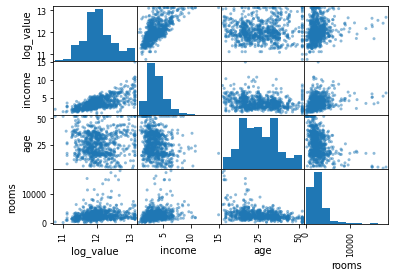

In [22]:
# SAMPLE COORELATION PLOT

houses_train_splom_vars = \
    houses_selected_train.loc[:, ['log_value', 'income', 'age', 'rooms']]
scatter_matrix(houses_train_splom_vars)


In [12]:
# --------------------------------------------
# Linear regression a la Pace and Barry (1997)
# --------------------------------------------
# fit the model to the training set
pace_barry_train_fit = smf.ols(pace_barry_model, \
    data = houses_selected_train).fit()
# summary of model fit to the training set
print(pace_barry_train_fit.summary())
# training set predictions from the model fit to the training set
houses_selected_train['predict_log_value'] = pace_barry_train_fit.fittedvalues
# test set predictions from the model fit to the training set
houses_selected_test['predict_log_value'] = pace_barry_train_fit.predict(houses_selected_test)

# compute the proportion of response variance for training data
pace_and_barry_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['predict_log_value']),2),3)
print('\nPace and Barry Proportion of Training Set Variance Accounted for: ',\
    pace_and_barry_train_result)

# compute the proportion of response variance
# accounted for when predicting out-of-sample
pace_and_barry_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['predict_log_value']),2),3)
print('\nPace and Barry Proportion of Test Set Variance Accounted for: ',\
    pace_and_barry_test_result)

                            OLS Regression Results                            
Dep. Variable:              log_value   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     176.8
Date:                Tue, 08 Sep 2020   Prob (F-statistic):          7.51e-170
Time:                        20:52:08   Log-Likelihood:                -62.370
No. Observations:                 793   AIC:                             142.7
Df Residuals:                     784   BIC:                             184.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.3731      0.154     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [13]:
# --------------------------------------
# Tree-structured regression (simple)
# --------------------------------------
# try tree-structured regression on the original explantory variables
# note that one of the advantages of trees is no need for transformations
# of the explanatory variables... sklearn DecisionTreeRegressor
tree_model_maker = DecisionTreeRegressor(random_state = 9999, max_depth = 5)

y_train = houses_selected_train.loc[:, ['log_value']]

# simple model has six predictors
X_train_simple = houses_selected_train.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]
X_test_simple = houses_selected_test.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]

tree_model_fit = tree_model_maker.fit(X_train_simple, y_train)

# compute the proportion of response variance for training data
houses_selected_train['simple_tree_predict_log_value'] =\
    tree_model_fit.predict(X_train_simple)
simple_tree_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['simple_tree_predict_log_value']),2),3)
print('\nSimple Tree Proportion of Training Set Variance Accounted for: ',\
    simple_tree_train_result)

# compute the proportion of response variance for test data
houses_selected_test['simple_tree_predict_log_value'] =\
    tree_model_fit.predict(X_test_simple)
simple_tree_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['simple_tree_predict_log_value']),2),3)
print('\nSimple Tree Proportion of Test Set Variance Accounted for: ',\
    simple_tree_test_result)



Simple Tree Proportion of Training Set Variance Accounted for:  0.621

Simple Tree Proportion of Test Set Variance Accounted for:  0.461


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# --------------------------------------
# Tree-structured regression (full)
# --------------------------------------
# same method as for simple tree
tree_model_maker = DecisionTreeRegressor(random_state = 9999, max_depth = 5)

y_train = houses_selected_train.loc[:, ['log_value']]

# full model has more predictors
X_train_full = houses_selected_train.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms',\
        'pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]
X_test_full = houses_selected_test.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms',\
        'pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]

tree_model_fit = tree_model_maker.fit(X_train_full, y_train)

# compute the proportion of response variance for training data
houses_selected_train['full_tree_predict_log_value'] =\
    tree_model_fit.predict(X_train_full)
full_tree_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['full_tree_predict_log_value']),2),3)
print('\nFull Tree Proportion of Training Set Variance Accounted for: ',\
    full_tree_train_result)

# compute the proportion of response variance for test data
houses_selected_test['full_tree_predict_log_value'] =\
    tree_model_fit.predict(X_test_full)
full_tree_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['full_tree_predict_log_value']),2),3)
print('\nFull Tree Proportion of Test Set Variance Accounted for: ',\
    full_tree_test_result)



Full Tree Proportion of Training Set Variance Accounted for:  0.729

Full Tree Proportion of Test Set Variance Accounted for:  0.612


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
# --------------------------------------
# Random forests (simple)
# --------------------------------------
rf_model_maker = RandomForestRegressor(random_state = 9999)

y_train = houses_selected_train.loc[:, ['log_value']]

# simple model has more predictors
X_train_simple = houses_selected_train.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]
X_test_simple = houses_selected_test.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms', 'pop', 'hh']]

rf_model_fit = rf_model_maker.fit(X_train_simple, y_train)

# compute the proportion of response variance for training data
houses_selected_train['simple_rf_predict_log_value'] =\
    rf_model_fit.predict(X_train_simple)
simple_rf_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['simple_rf_predict_log_value']),2),3)
print('\nSimple Random Forest Prop Training Set Variance Accounted for: ',\
    simple_rf_train_result)

# compute the proportion of response variance for test data
houses_selected_test['simple_rf_predict_log_value'] =\
    rf_model_fit.predict(X_test_simple)
simple_rf_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['simple_rf_predict_log_value']),2),3)
print('\nSimple Random Forest Prop of Test Set Variance Accounted for: ',\
    simple_rf_test_result)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':



Simple Random Forest Prop Training Set Variance Accounted for:  0.955

Simple Random Forest Prop of Test Set Variance Accounted for:  0.592


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
# --------------------------------------
# Random forests (full)
# --------------------------------------
rf_model_maker = RandomForestRegressor(random_state = 9999)

y_train = houses_selected_train.loc[:, ['log_value']]

# full model has more predictors
X_train_full = houses_selected_train.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms',\
        'pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]
X_test_full = houses_selected_test.loc[:, \
    ['income', 'age', 'rooms', 'bedrooms',\
        'pop', 'hh', 'log_pc_rooms', 'log_pc_bedrooms', 'log_pop_hh']]

rf_model_fit = rf_model_maker.fit(X_train_full, y_train)

# compute the proportion of response variance for training data
houses_selected_train['full_rf_predict_log_value'] =\
    rf_model_fit.predict(X_train_full)
full_rf_train_result = \
    round(np.power(houses_selected_train['log_value']\
        .corr(houses_selected_train['full_rf_predict_log_value']),2),3)
print('\nFull Random Forest Prop of Training Set Variance Accounted for: ',\
    full_rf_train_result)

# compute the proportion of response variance for test data
houses_selected_test['full_rf_predict_log_value'] =\
    rf_model_fit.predict(X_test_full)
full_rf_test_result = \
    round(np.power(houses_selected_test['log_value']\
        .corr(houses_selected_test['full_rf_predict_log_value']),2),3)
print('\nFull Random Forest Prop of Test Set Variance Accounted for: ',\
    full_rf_test_result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':



Full Random Forest Prop of Training Set Variance Accounted for:  0.961

Full Random Forest Prop of Test Set Variance Accounted for:  0.659


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
# --------------------------------------
# Geographically weighted regression
# --------------------------------------    
# exercise for the student
# use rpy2 to obtain results from R
full_gwr_train_result = None
full_gwr_test_result = None

# --------------------------------------
# Gather results for a single report
# --------------------------------------     
# measurement model performance summary
table_data = {'method' : ['Linear regression Pace and Barry (1997)',\
    'Tree-structured regression (simple model)',\
    'Tree-structured regression (full model)',\
    'Random forests (simple model)',\
    'Random forests (full model)',\
    'Geographically weighted regression (GWR)'],\
    'Training Set Result' : [pace_and_barry_train_result,\
    simple_tree_train_result,\
    full_tree_train_result,\
    simple_rf_train_result,\
    full_rf_train_result,\
    full_gwr_train_result],\
    'Test Set Result' : [pace_and_barry_test_result,\
    simple_tree_test_result,\
    full_tree_test_result,\
    simple_rf_test_result,\
    full_rf_test_result,\
    full_gwr_test_result]}
  
table_data_frame = pd.DataFrame(table_data,\
    columns = ['method', 'Training Set Result', 'Test Set Result'])  
    
print(table_data_frame)    

                                      method  ...  Test Set Result
0    Linear regression Pace and Barry (1997)  ...            0.568
1  Tree-structured regression (simple model)  ...            0.461
2    Tree-structured regression (full model)  ...            0.612
3              Random forests (simple model)  ...            0.592
4                Random forests (full model)  ...            0.659
5   Geographically weighted regression (GWR)  ...              NaN

[6 rows x 3 columns]
